# ChemROAR Demo Notebook

In [1]:
import pandas as pd
import torch
import ROAR
from utils import make_binary_plot
from rdkit.Chem import MolFromSmiles, Draw
from rdkit import RDLogger
import matplotlib.pyplot as plt
RDLogger.DisableLog('rdApp.*')

/home/jovyan/chem/ChemROAR/ROPE.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/jovyan/chem/ChemROAR/ROPE.py:259: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


## Function to load various sample molecule datasets. 
## We will use the HIV dataset which contains molecules which either do or do not inhibit HIV replication

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load the model

In [3]:
model = ROAR.ChemROAR.from_pretrained("willbaskett/ChemROAR").to(device)

## Load the HIV dataset

In [5]:
data = pd.read_csv("resources/HIV.csv")
data

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0
...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0


## Make Embeddings

In [6]:
#This will take a little while. We use batches of 64 here.
X = pd.DataFrame(model.embed(data.smiles, batch=64)).round().astype(bool)
y = data.HIV_active.copy()

## Prepare Encodings For Analysis

In [7]:
#add "label" column to encodings which is what the following analysis function wants
encodings = X.copy()
encodings["label"] = y
encodings

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
0,False,False,True,False,False,False,True,True,True,False,...,True,False,True,True,False,False,False,False,True,0
1,False,True,True,False,False,False,True,True,True,True,...,False,False,False,True,True,False,True,False,True,0
2,False,True,False,False,False,False,False,True,False,False,...,True,False,False,True,False,True,False,False,False,0
3,False,False,True,False,True,False,True,False,False,False,...,False,False,True,False,False,True,True,True,True,0
4,False,False,False,False,False,False,False,True,False,False,...,False,True,False,False,False,True,True,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41122,False,True,False,False,False,False,True,True,True,True,...,True,False,False,False,True,False,False,False,True,0
41123,False,False,True,False,True,False,True,True,True,True,...,True,False,False,False,False,False,False,False,True,0
41124,False,False,False,False,True,False,True,True,True,True,...,True,False,False,False,False,False,False,False,True,0
41125,False,False,False,False,True,False,True,True,True,True,...,True,False,False,False,False,False,False,False,True,0


## Figure out which clusters have molecules which inhibiy HIV replication at an abnormally high rate
#### 93% of molecules in the best cluster inhibit HIV. 
#### The 99% confidence interval shows that the true probability of molecules in this cluster inhibiting HIV replication has a 99% chance of being at least 59.84%.

/opt/conda/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


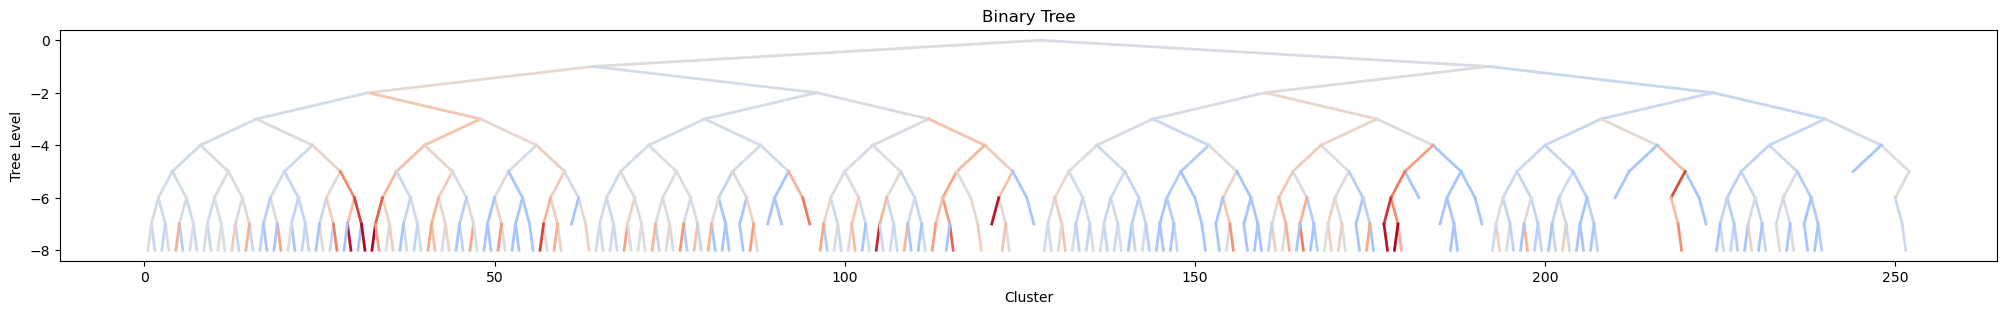

key                   []
Node Depth             0
Cluster Mean    0.035086
99% CI Low      0.032791
99% CI High      0.03749
Count              41127
Z                    0.0
P                    1.0
Name: 0, dtype: object


,key,Node Depth,Cluster Mean,99% CI Low,99% CI High,Count,Z,P,FDR Adjusted P,Whole Population Mean
169007,"[False, False, True, False, False, False, Fals...",23,0.933333,0.598408,0.999666,15,18.819349,5.242452e-79,3.260035e-76,0.035086
140774,"[False, False, True, False, False, False, Fals...",22,0.894737,0.596321,0.994419,19,20.250274,3.532689e-91,2.510644e-88,0.035086
69477,"[False, False, True, False, False, False, Fals...",19,0.818182,0.591287,0.950766,33,24.231127,1.045605e-129,1.040340e-126,0.035086
115251,"[False, False, True, False, False, False, Fals...",21,0.812500,0.580522,0.949134,32,23.695811,3.982701e-124,3.302207e-121,0.035086
51129,"[False, False, True, False, False, False, Fals...",18,0.670213,0.533708,0.788966,94,32.783631,1.007654e-235,5.012903e-232,0.035086
35855,"[False, False, True, False, False, False, Fals...",17,0.663158,0.527154,0.782330,95,32.591449,5.420993e-233,1.348424e-229,0.035086
23978,"[False, False, True, False, False, False, Fals...",16,0.659794,0.525168,0.778277,97,32.745848,3.478957e-235,1.153813e-231,0.035086
199312,"[False, False, True, False, False, False, Fals...",24,0.916667,0.522974,0.999582,12,16.536647,1.998413e-61,8.284796e-59,0.035086
15551,"[False, False, True, False, False, False, Fals...",15,0.627451,0.495540,0.747129,102,31.840646,1.773562e-222,2.941053e-219,0.035086
115593,"[False, False, True, False, False, False, Fals...",21,0.660377,0.474943,0.816259,53,24.455882,4.357151e-132,4.816903e-129,0.035086


In [8]:
#get clusters of molecules most associated with inhibiting HIV replication, plot tree, this is a bit slow
clusters = make_binary_plot(encodings).sort_values("99% CI Low", ascending=False)
clusters[:10]

## Get the best cluster

In [9]:
#get the node associated with the best cluster, defined as a T/F traversal of the tree
target_node_vector = torch.tensor(clusters.iloc[0].key).float()

## Generate roughly 100 molecules which are part of this cluster
### This function generates molecules conditioned on the embedding and then checks to make sure that they match it at the end

In [10]:
#Generate roughly 100 molecules which are part of the best cluster
#Don't try without a GPU
possible_solutions = []
while len(possible_solutions) < 100:
    generated_molecules = model.generate_molecules(target_node_vector, batch_size=128, evaluate_after_n_tokens=128, temperature=1, topk=500, topp=0.95)
    possible_solutions += generated_molecules
    possible_solutions = list(set(possible_solutions))
    print(f"{len(possible_solutions)} total molecules found so far")

#scramble the order since some were generated together as part of the same root
possible_solutions = list(pd.Series(possible_solutions).sample(frac=1))

Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

9 possibly valid sequences
9 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

4 possibly valid sequences
13 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

12 possibly valid sequences
25 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

4 possibly valid sequences
41 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

3 possibly valid sequences
45 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

6 possibly valid sequences
51 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

5 possibly valid sequences
56 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

5 possibly valid sequences
61 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

5 possibly valid sequences
66 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

5 possibly valid sequences
71 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

3 possibly valid sequences
74 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

2 possibly valid sequences
75 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

5 possibly valid sequences
80 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

4 possibly valid sequences
84 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

8 possibly valid sequences
92 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

1 possibly valid sequences
93 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

6 possibly valid sequences
106 total molecules found so far


In [11]:
#shows molecules plotted in a grid
def show_molecule_grid(smiles, rows, cols):
    """
    Display a grid of molecule images.
    
    Parameters:
        mols (list): List of molecule images (e.g., PIL Images from RDKit).
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
    """
    #make images
    mols = []
    for s in smiles:
        m = MolFromSmiles(s)
        mols.append(Draw.MolToImage(m))
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    
    # In case rows*cols == 1, axes won't be a list, so we ensure it's iterable.
    if rows * cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # Loop over each grid cell and display the molecule image if available.
    for i in range(rows * cols):
        ax = axes[i]
        if i < len(mols):
            ax.imshow(mols[i])
        ax.axis('off')  # Hide the axes ticks and labels.
    
    plt.tight_layout()
    plt.show()

## Molecules which are highly likely to inhibit HIV replication
### We can see obvious similarities between molecules in this cluster

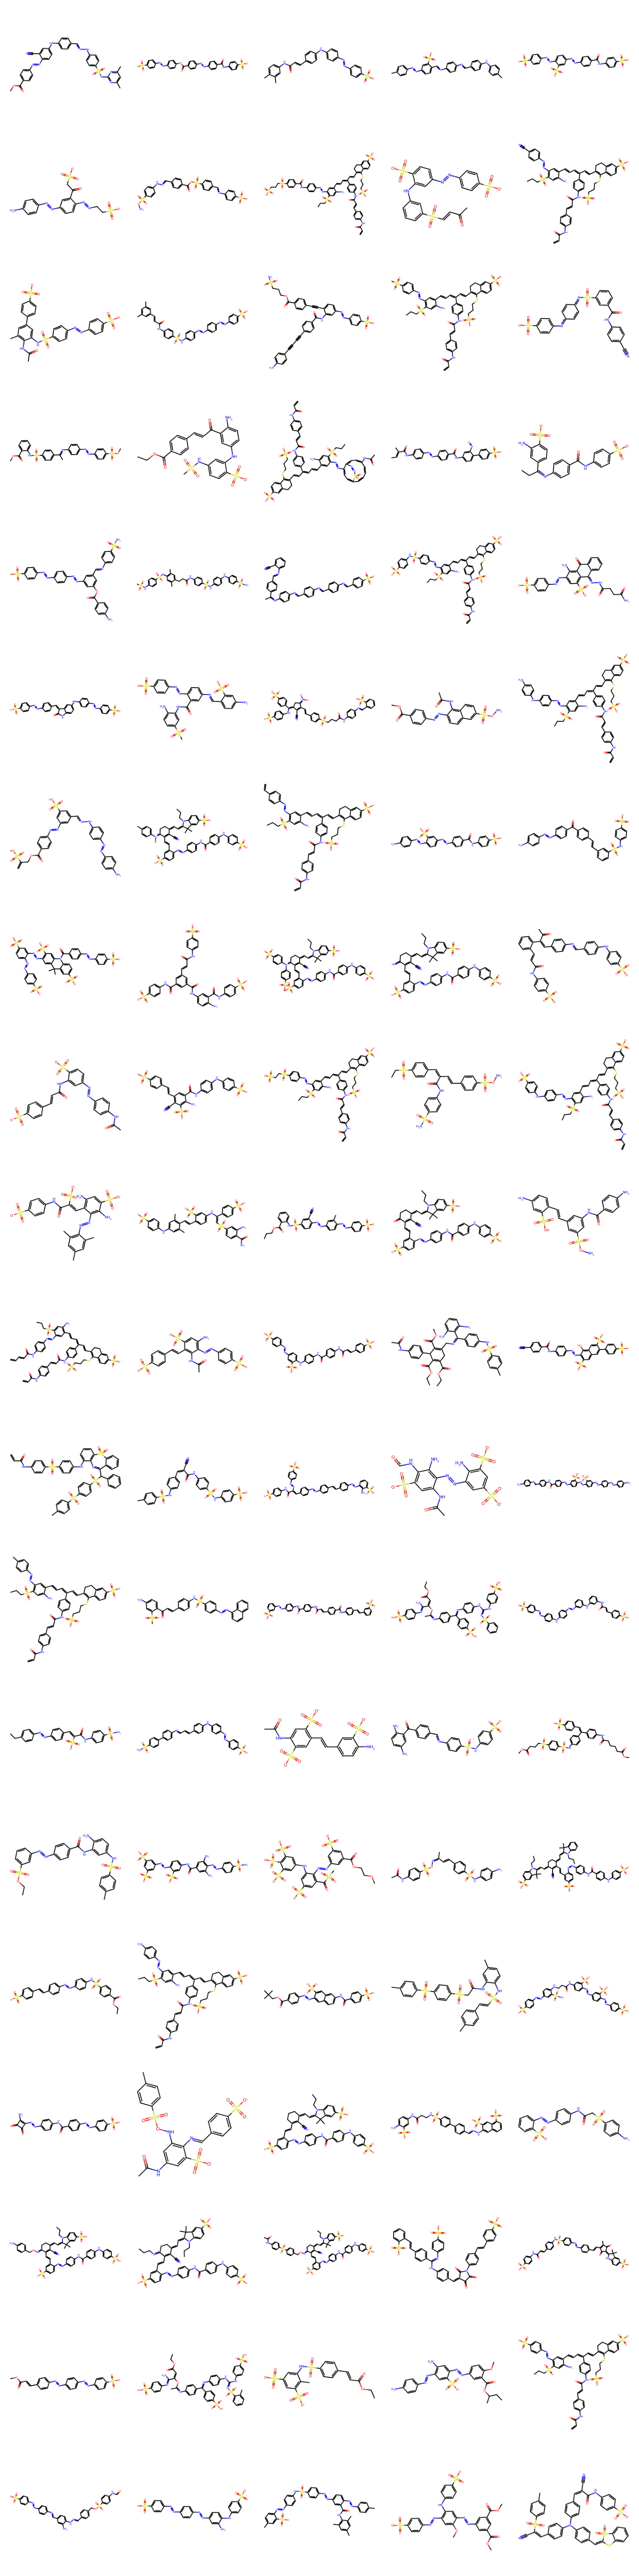

In [12]:
show_molecule_grid(possible_solutions, 20, 5)